# **Removal Prediction Filler**

**Student/Author:** Salvador Robles<br>
**Class:** Computer Vision CS4363/5363<br>
**Professor:** Olac Fuentes<br>
**Semester:** Fall 2022<br>
**Last modified:** 12/6/2022<br>

## **Introduction**

Computer Vision enables the learning of knowledge from images, this semester we went over different topics over the vast field of Computer Vision. This final project will showcase some of the concepts we learnt in class and how it can be applied to real world applications.

My idea for this final project is to create some sort of Removal Filter. Wheneven you take a photo there will be a point where you will face the necessity to erase something that is present in the picture. This project tries the idea to use Computer Vision and Deep Learning to having an input image, as well as the the prediction box where you want to erase, and then to predict an image where the deleted part becomes another part of the background.

After the introduction there will be a section for downloading and setting up the training and testing data. After this we will do some Data Analysis to see what valuable information we can get before training our deep learning models. After analysing our data we will be ready to do some data Pre processing so that we are ready to train with our data. Finally we will be experimenting with different approaches to tackle this problem, like Convolution, Partial Convolution and an Encoder/Decoder approach.

An example of what I'm trying to achieve is like the following. As you can see the people in the background are no longer in the image:

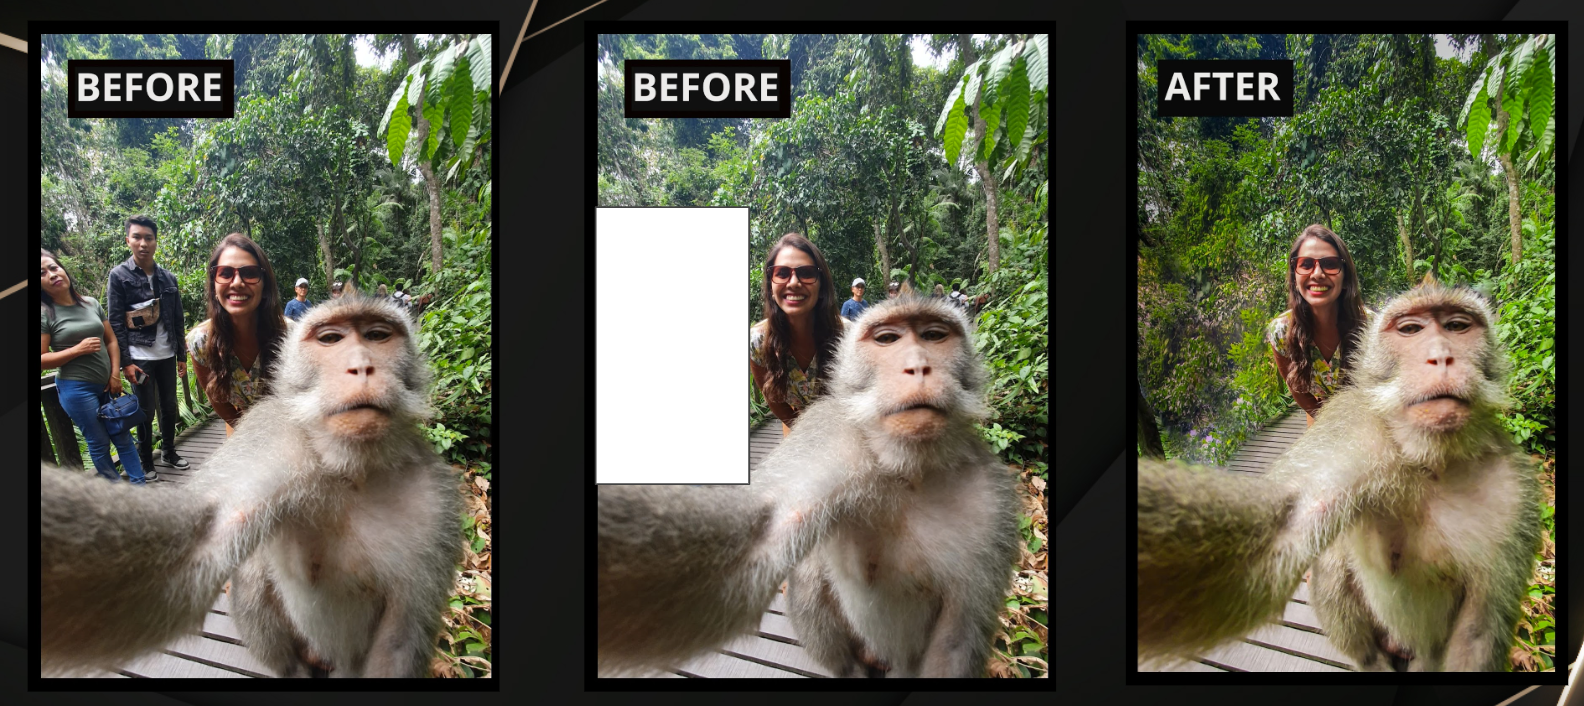

## **Set Up**

This section downloads a lot of images from the COCO dataset https://cocodataset.org/#download. The Common Object in Context (COCO) is a large-scale object detection dataset. We are only interested in the images and not in the segmentation and object detection metadata, so I'm downloading only some sample of images.

In [ ]:
import numpy as np
import pandas as pd
import os, sys
from matplotlib import pyplot as plt
import plotly.graph_objs as plotly  # for interactive plots
import plotly.express as px
import tensorflow as tf
from tensorflow import keras
from keras import metrics
from skimage.transform import resize
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

In [ ]:
! mkdir coco
! cd coco
! mkdir images
! cd images

! wget -c http://images.cocodataset.org/zips/test2017.zip

! unzip test2017.zip

! rm test2017.zip

Streaming output truncated to the last 5000 lines.
 extracting: test2017/000000251604.jpg  
 extracting: test2017/000000145034.jpg  
 extracting: test2017/000000234833.jpg  
 extracting: test2017/000000025927.jpg  
 extracting: test2017/000000393116.jpg  
 extracting: test2017/000000536478.jpg  
 extracting: test2017/000000365460.jpg  
 extracting: test2017/000000089887.jpg  
 extracting: test2017/000000274928.jpg  
 extracting: test2017/000000310028.jpg  
 extracting: test2017/000000229793.jpg  
 extracting: test2017/000000394339.jpg  
 extracting: test2017/000000564538.jpg  
 extracting: test2017/000000440585.jpg  
 extracting: test2017/000000541512.jpg  
 extracting: test2017/000000395525.jpg  
 extracting: test2017/000000235435.jpg  
 extracting: test2017/000000069964.jpg  
 extracting: test2017/000000131962.jpg  
 extracting: test2017/000000281392.jpg  
 extracting: test2017/000000534893.jpg  
 extracting: test2017/000000128676.jpg  
 extracting: test2017/000000187639.jpg  
 extra

In total there will be around 40k images. First I will use only a handful of images and then try experimenting with more while the session doesn't crash due to RAM availability and space issues.

In [ ]:
import os
# folder path
dir_path = r'/content/test2017'
num_images = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        num_images += 1
print('Number of images:', num_images)

Number of images: 40670


All 40k images are know in the /context/test2017 folder in Colab.

To further manipulate our data we need to transform the data into Numpy arrays. Note that the the original images are the our predictions or Ground truth Y.

Aside from this, the images will be resized to 200x200 pixels. This because most ML models expect inputs to be of the same size and the images on the COCO dataset have different shapes. The resize function from the **transform** module from **skimage** is used to have the same number of dimensions for each of the images in our dataset.

In [ ]:
directory = '/content/test2017'

num_images = 2000 # Number of images that are going to be used from datasset
length = 200 # Dimension 1 for image
width = 200 # Dimensino 2 for image
Y = np.zeros((num_images, length, width, 3)) # Our Y will be the original images

# iterate over files in the specified directory
i = 0
for filename in os.listdir(directory):
    if i == num_images:
      break
    f = os.path.join(directory, filename)
    if i % 200 == 0: # See progress creating numpy array
      print('Number of images so far: ', i)

    img = plt.imread(directory + "/" + filename)
    Y[i] = resize(img, output_shape=(length, width, 3)) # Resizing image size to the specified
    i += 1

Number of images so far:  0
Number of images so far:  200
Number of images so far:  400
Number of images so far:  600
Number of images so far:  800
Number of images so far:  1000


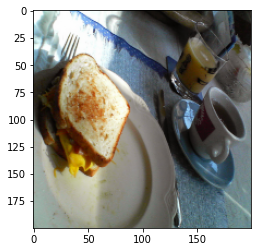

In [ ]:
# Example of Ground truth 2
plt.imshow(Y[2])

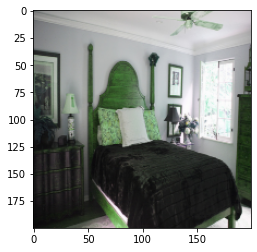

In [ ]:
# Example of Ground truth 10
plt.imshow(Y[10])

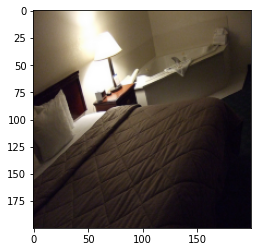

In [ ]:
# Example of Ground truth 990
plt.imshow(Y[990])

## Data Pre-Processing

The next step is to Pre-Process the data to create an actual input for our Neural Network. This section will create some "holes" in the images so that our model can predict the missing parts. The new images created will be our input X. Given this image X as the input we will predict the ground truth Y.

This holes will be created in a random location of the image, the bottom left coordinate will be randonmly selected and then fill with black pixels 0.0 intensity on the RGB channels. Note that the image will be previously modified so that 0.0 pixels are converted into 0.1, this so that the model doesn't confuse the square to predict.

In [ ]:
import random

def create_new_images_X(Y, square_size):
  X = np.zeros(Y.shape)
  for i in range(Y.shape[0]):
    img = np.copy(Y[i])
    img[img == 0.0] = 0.1 # Normalize data
    val_x = random.randint(0, length - square_size - 1)
    val_y = random.randint(0, width - square_size - 1)

    for k in range(val_x,val_x+square_size):
      for j in range(val_y, val_y+square_size):
        img[k][j] = 0.0
    X[i] = img

  return X

square_size = 40
X = create_new_images_X(Y, square_size)

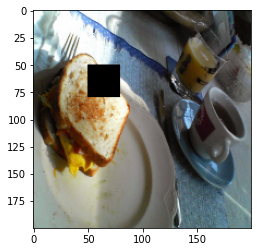

In [ ]:
# Example of Input 2
plt.imshow(X[2])

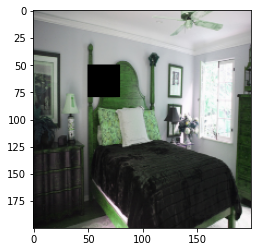

In [ ]:
# Example of Input 10
plt.imshow(X[10])

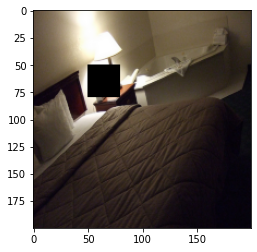

In [ ]:
# Example of Input 990
plt.imshow(X[990])

## Data Analysis

We will do some basic analysis on our data to see what valuable information we can gather.

In [ ]:
dimension_area = length * width
print('Number of pixels to predict per image: ', dimension_area)



Number of pixels to predict per image:  40000


## Traint and Test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0, train_size = .9)

In [ ]:
# Shape of X _train, X_test, y_train, y_test
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1800, 200, 200, 3)
(200, 200, 200, 3)
(1800, 200, 200, 3)
(200, 200, 200, 3)


# Models

## Model 1

Simple Convolutional model which the input is an image with a missing hole. The output must be an image as well 200x200x3. The result of the Convolutional layers.

In [ ]:
def plot_history(history):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.legend()
  plt.show()

In [ ]:
def cnn_model(input_shape=(200,200,3),dropout=0.1):
  model = tf.keras.models.Sequential()
  model.add(Conv2D(30, kernel_size=(5, 5), input_shape=input_shape,  padding='same', activation="relu"))
  model.add(Conv2D(30, kernel_size=(5, 5), activation="relu", padding='same'))
  model.add(Conv2D(30, kernel_size=(5, 5), activation="relu", padding='same'))
  model.add(Conv2D(30, kernel_size=(5, 5), activation="relu", padding='same'))
  model.add(Conv2D(3, kernel_size=(5, 5), activation="relu", padding='same'))
  return model

In [ ]:
X_train.shape[1:]
print(X_train[:10].shape)

(10, 200, 200, 3)


Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_195 (Conv2D)         (None, 200, 200, 30)      2280      
                                                                 
 conv2d_196 (Conv2D)         (None, 200, 200, 30)      22530     
                                                                 
 conv2d_197 (Conv2D)         (None, 200, 200, 30)      22530     
                                                                 
 conv2d_198 (Conv2D)         (None, 200, 200, 30)      22530     
                                                                 
 conv2d_199 (Conv2D)         (None, 200, 200, 3)       2253      
                                                                 
Total params: 72,123
Trainable params: 72,123
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
1800/1800 [===========================

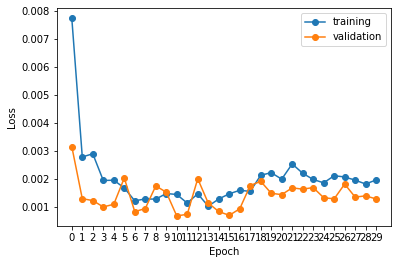

In [ ]:
model =  cnn_model(input_shape = X_train.shape[1:])
model.summary()
model.compile(loss="mean_squared_error", metrics=["mean_squared_error"], optimizer = 'adam')

history = model.fit(
  # X_train[:100], y_train[:100],
  X_train, y_train,
  epochs =  30, # Number of times the whole training set will be seen by the network
  batch_size = 1, # Number of training examples seen for every weight update
  verbose = 1,
  validation_data=(X_test, y_test),
)

history = pd.DataFrame(history.history)
plot_history(history)

In [ ]:
preds_model1 = model.predict(X_test)

7/7 [==============================] - 0s 15ms/step


In [ ]:
preds_model1.shape

(200, 200, 200, 3)

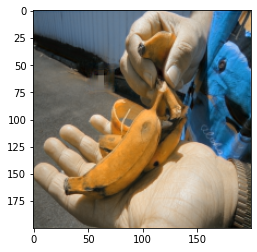

In [ ]:
plt.imshow(preds_model1[100])

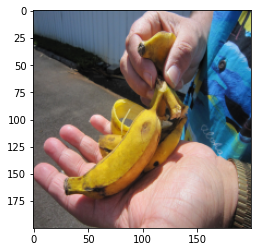

In [ ]:
plt.imshow(y_test[100])

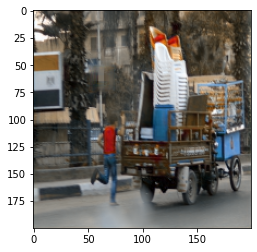

In [ ]:
plt.imshow(preds_model1[15])

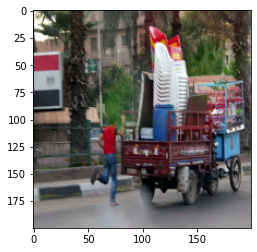

In [ ]:
plt.imshow(y_test[15])

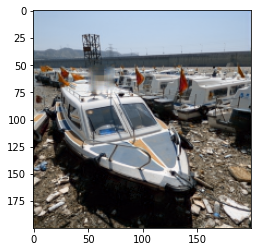

In [ ]:
plt.imshow(preds_model1[25])

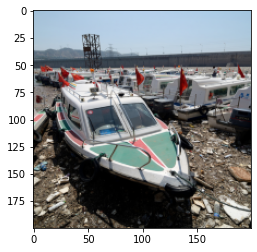

In [ ]:
plt.imshow(y_test[25])

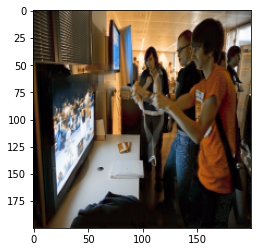

In [ ]:
plt.imshow(preds_model1[50])

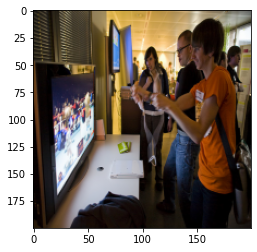

In [ ]:
plt.imshow(y_test[50])

## Model 2

The idea is to create an Autoencoder. Encode part to minimize shape of image. Decoder to increase image to something.

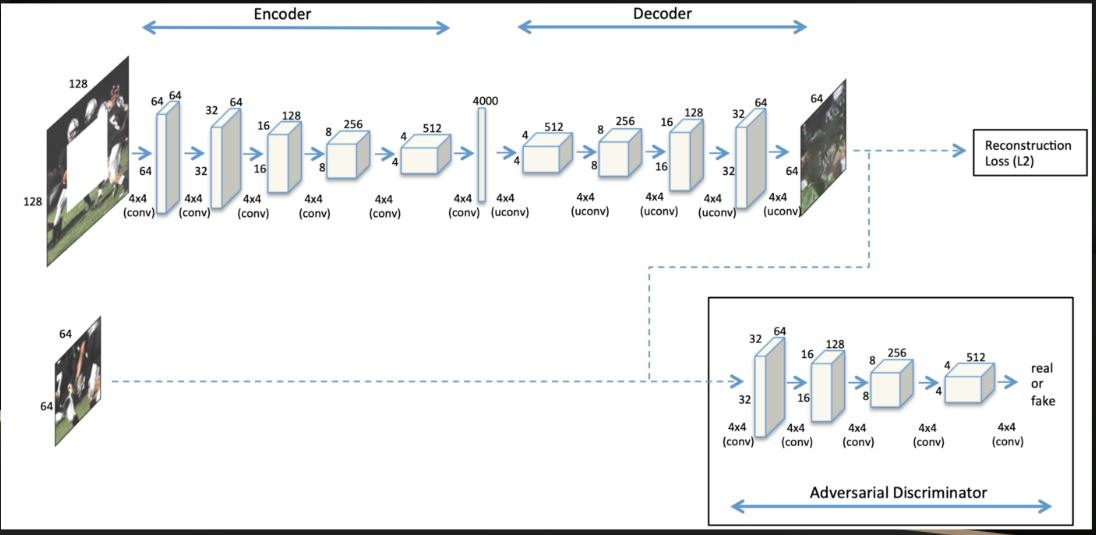

In [ ]:
latent_dim = 300

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(length*width*3, activation='sigmoid'),
      layers.Reshape((length,width,3))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
# Note that you put x_train as x as well as x_train as y

autoencoder.fit(X_train, y_train,
                epochs=100,
                batch_size = 16, # Number of training examples seen for every weight update
                verbose = 1,
                validation_data=(X_test, y_test))

autoencoder.summary()

Epoch 1/100
113/113 [==============================] - 2s 11ms/step - loss: 0.0717 - val_loss: 0.0710
Epoch 2/100
113/113 [==============================] - 1s 9ms/step - loss: 0.0694 - val_loss: 0.0704
Epoch 3/100
113/113 [==============================] - 1s 9ms/step - loss: 0.0690 - val_loss: 0.0699
Epoch 4/100
113/113 [==============================] - 1s 9ms/step - loss: 0.0681 - val_loss: 0.0696
Epoch 5/100
113/113 [==============================] - 1s 9ms/step - loss: 0.0674 - val_loss: 0.0693
Epoch 6/100
113/113 [==============================] - 1s 9ms/step - loss: 0.0669 - val_loss: 0.0687
Epoch 7/100
113/113 [==============================] - 1s 9ms/step - loss: 0.0666 - val_loss: 0.0683
Epoch 8/100
113/113 [==============================] - 1s 9ms/step - loss: 0.0661 - val_loss: 0.0680
Epoch 9/100
113/113 [==============================] - 1s 9ms/step - loss: 0.0656 - val_loss: 0.0674
Epoch 10/100
113/113 [==============================] - 1s 9ms/step - loss: 0.0654 - val_l

In [ ]:
preds_model2 = autoencoder.predict(X_test)

7/7 [==============================] - 0s 5ms/step


In [ ]:
preds_model2.shape

(200, 200, 200, 3)

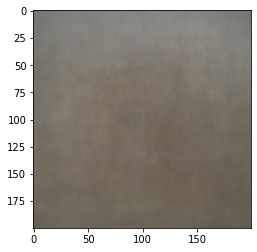

In [ ]:
plt.imshow(preds_model2[3])

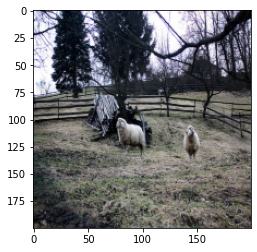

In [ ]:
plt.imshow(y_test[3])

## Model 3

In [ ]:
class Autoencoder_Conv(Model):
  def __init__(self):
    super(Autoencoder_Conv, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(200, 200, 3)),
      layers.Conv2D(3, kernel_size=(3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same')])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(32, kernel_size=(3, 3), activation="relu", padding='same'),
      layers.Conv2DTranspose(8, kernel_size=(3,3), strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(3, kernel_size=(3,3), strides=2, activation='relu', padding='same'),
      layers.Conv2D(3, kernel_size=(5, 5), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder_conv = Autoencoder_Conv()

In [ ]:
autoencoder_conv.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
# Note that you put x_train as x as well as x_train as y

autoencoder_conv.fit(X_train, y_train,
                epochs=150,
                batch_size = 4,
                validation_data=(X_test, y_test))


Epoch 1/150
450/450 [==============================] - 3s 6ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 2/150
450/450 [==============================] - 2s 5ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 3/150
450/450 [==============================] - 2s 5ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 4/150
450/450 [==============================] - 2s 5ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 5/150
450/450 [==============================] - 2s 5ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 6/150
450/450 [==============================] - 2s 5ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 7/150
450/450 [==============================] - 2s 5ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 8/150
450/450 [==============================] - 2s 5ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 9/150
450/450 [==============================] - 2s 5ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 10/150
450/450 [==============================] - 2s 5ms/step - loss: 0.0019 - val_lo

In [ ]:
autoencoder_conv.summary()

Model: "autoencoder__conv_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_52 (Sequential)  (None, 50, 50, 32)        2644      
                                                                 
 sequential_53 (Sequential)  (None, 200, 200, 3)       12007     
                                                                 
Total params: 14,651
Trainable params: 14,651
Non-trainable params: 0
_________________________________________________________________


In [ ]:
preds_model3 = autoencoder_conv.predict(X_test)

7/7 [==============================] - 0s 6ms/step


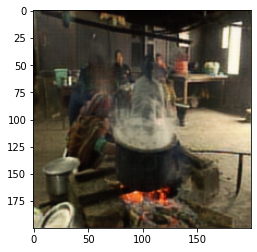

In [ ]:
plt.imshow(preds_model3[2])

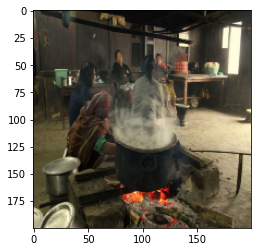

In [ ]:
plt.imshow(y_test[2])

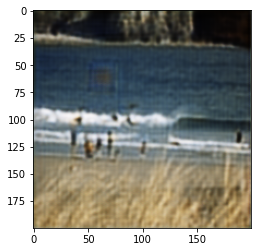

In [ ]:
plt.imshow(preds_model3[30])

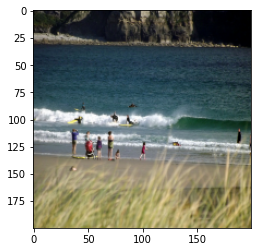

In [ ]:
plt.imshow(y_test[30])

In [ ]:
class Autoencoder_Conv_2(Model):
  def __init__(self):
    super(Autoencoder_Conv_2, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(200, 200, 3)),
      layers.Conv2D(3, kernel_size=(3, 3), activation='relu', padding='same', strides = 2),
      layers.Conv2D(3, kernel_size=(3, 3), activation='relu', padding='same', strides = 2),
      layers.Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same', strides = 2),
      layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', strides = 2),
      layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
      layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(64, kernel_size=(3, 3), activation="relu", padding='same')
      layers.Conv2DTranspose(32, kernel_size=(3, 3), activation="relu", padding='same'),
      layers.Conv2DTranspose(16, kernel_size=(3,3), strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(8, kernel_size=(3,3), strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(3, kernel_size=(3,3), strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(3, kernel_size=(3,3), strides=2, activation='relu', padding='same'),
      layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder_conv_2 = Autoencoder_Conv_2()

"""class Autoencoder_Conv_2(Model):
  def __init__(self):
    super(Autoencoder_Conv_2, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(200, 200, 3)),
      layers.Conv2D(3, kernel_size=(3, 3), activation='relu', padding='same'),
      layers.Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same'),
      layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
      layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
      layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding='same')])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(64, kernel_size=(3, 3), activation="relu", padding='same'),
      layers.Conv2DTranspose(32, kernel_size=(3, 3), activation="relu", padding='same'),
      layers.Conv2DTranspose(16, kernel_size=(3,3), strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(8, kernel_size=(3,3), strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(3, kernel_size=(3,3), strides=2, activation='relu', padding='same'),
      layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder_conv_2 = Autoencoder_Conv_2()"""

'class Autoencoder_Conv_2(Model):\n  def __init__(self):\n    super(Autoencoder_Conv_2, self).__init__()\n    self.encoder = tf.keras.Sequential([\n      layers.Input(shape=(200, 200, 3)),\n      layers.Conv2D(3, kernel_size=(3, 3), activation=\'relu\', padding=\'same\'),\n      layers.Conv2D(8, kernel_size=(3, 3), activation=\'relu\', padding=\'same\'),\n      layers.Conv2D(16, kernel_size=(3, 3), activation=\'relu\', padding=\'same\'),\n      layers.Conv2D(32, kernel_size=(3, 3), activation=\'relu\', padding=\'same\'),\n      layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding=\'same\')])\n\n    self.decoder = tf.keras.Sequential([\n      layers.Conv2DTranspose(64, kernel_size=(3, 3), activation="relu", padding=\'same\'),\n      layers.Conv2DTranspose(32, kernel_size=(3, 3), activation="relu", padding=\'same\'),\n      layers.Conv2DTranspose(16, kernel_size=(3,3), strides=2, activation=\'relu\', padding=\'same\'),\n      layers.Conv2DTranspose(8, kernel_size=(3,3), strid

In [ ]:
autoencoder_conv_2.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
# Note that you put x_train as x as well as x_train as y

autoencoder_conv_2.fit(X_train, y_train,
                epochs=100,
                batch_size = 6,
                validation_data=(X_test, y_test))


Epoch 1/100


ValueError: ignored

In [ ]:
autoencoder_conv_2.summary()

Model: "autoencoder__conv_2_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_66 (Sequential)  (None, 25, 25, 32)        6116      
                                                                 
 sequential_67 (Sequential)  (None, 200, 200, 3)       15335     
                                                                 
Total params: 21,451
Trainable params: 21,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
preds_model4 = autoencoder_conv_2.predict(X_test)

7/7 [==============================] - 0s 6ms/step


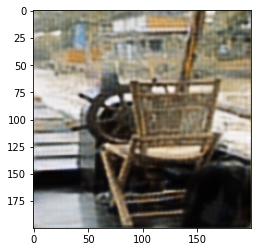

In [ ]:
plt.imshow(preds_model3[1])

In [ ]:
plt.imshow(y_test[1])

# Conclusion

Dense autoencoders

## References

During this project this were some of the resources I looked for guidance, from research papers to code ideas:

Links for code and ideas:
- https://cocodataset.org/#home
- https://blog.keras.io/building-autoencoders-in-keras.html
- https://keras.io/api/losses/regression_losses/#meansquarederror-class
- https://www.tensorflow.org/tutorials/generative/autoencoder
- https://towardsdatascience.com/how-to-make-an-autoencoder-2f2d99cd5103
- https://gaussian37.github.io/deep-learning-chollet-8-4/

Research papers:
- https://arxiv.org/pdf/1804.07723.pdf
- https://arxiv.org/pdf/1811.11718.pdf
